# 必要なライブラリを読み込む

In [135]:
from qore_sdk.client import WebQoreClient
import qore_sdk.utils

from sklearn import model_selection
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
import time
import numpy as np
import os

import matplotlib.pyplot as plt

# データの読み込み

In [136]:
def load_xyz(str_dir):
    with open(os.path.join(str_dir, 'x.txt'), 'r') as f:
        x = np.loadtxt(f, delimiter=',', usecols=1)
    with open(os.path.join(str_dir, 'y.txt'), 'r') as f:
        y = np.loadtxt(f, delimiter=',', usecols=1)
    with open(os.path.join(str_dir, 'z.txt'), 'r') as f:
        z = np.loadtxt(f, delimiter=',', usecols=1)
    return np.stack([x, y, z], 1)  # 2D-array

loading: ./data/udetate
loading: ./data/hukkin
loading: ./data/squat
loading: ./data/roller


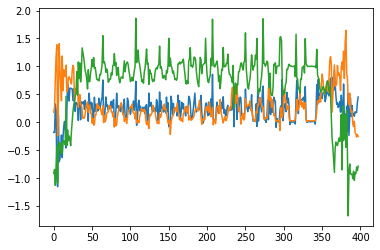

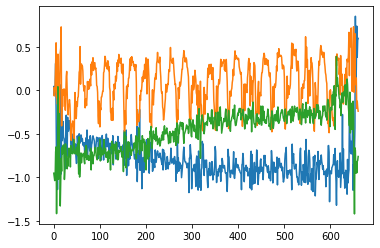

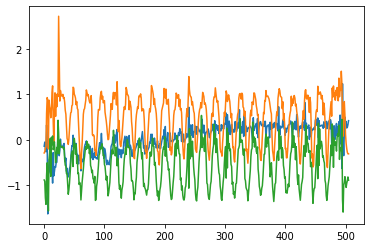

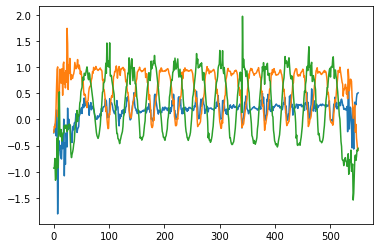

In [139]:
list_data = [
    './data/udetate', 
    './data/hukkin', 
    './data/squat', 
    './data/roller']

list_X = []
list_y = []
j_label = 0  # incremental label for each data
for i_data in list_data:
    print('loading: ' + i_data)
    array_loaded = load_xyz(i_data)
    list_X.append(array_loaded)
    array_label = np.repeat(j_label, array_loaded.shape[0])
    list_y.append(array_label)
    j_label += 1
    plt.figure()
    plt.plot(array_loaded)
X_all = np.concatenate(list_X, 0)
y_all = np.concatenate(list_y, 0)

# 時系列を複数の小時系列に分割する。

https://qcore-info.github.io/advent-calendar-2019/index.html#qore_sdk.utils.sliding_window

In [118]:
print(X_all.shape)
X_all, y_all = qore_sdk.utils.sliding_window(X_all, width=100, stepsize=1, axis=0, y=y_all, y_def='mode')
print(X_all.shape, y_all.shape)

(2116, 3)
(2017, 100, 3) (2017, 1)


# n_samples_per_classでクラス当たりのサンプル数を揃える。

https://qcore-info.github.io/advent-calendar-2019/index.html#qore_sdk.utils.under_sample

In [120]:
_, counts = np.unique(y_all, return_counts=True)
print(counts)

# サンプル数が一番少ないデータの数に合わせる
X, y = qore_sdk.utils.under_sample(X_all, y_all.flatten(), n_samples_per_class=counts.min())

_, counts = np.unique(y, return_counts=True)
print(counts)

[349 661 506 501]
[349 349 349 349]


# 学習データとテストデータに分割

In [127]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.2, random_state=1
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1116, 100, 3)
(1116,)
(280, 100, 3)
(280,)


# アカウント情報の入力

実際のアカウント情報を載せることはできないので、インタラクティブに入力するようにした

事前に発行されたユーザーネーム、パスワード、Endpointが必要  
詳しくは[Advent Calenderの公式Github](https://github.com/qcore-info/advent-calendar-2019)を参照

In [128]:
import getpass

username  = getpass.getpass(prompt='username: ', stream=None)
password = getpass.getpass(prompt='password: ', stream=None)
endpoint = getpass.getpass(prompt='endpoint: ', stream=None)

username: ········
password: ········
endpoint: ········


In [129]:
client = WebQoreClient(username=username, 
                       password=password, 
                       endpoint=endpoint)

学習を行う

In [130]:
start = time.time()
res = client.classifier_train(X=X_train, Y=y_train)
print(res)

{'res': 'ok', 'train_time': 7.2200915813446045}


`
classifier_test
`を用いると、精度が簡単に求められて便利




In [131]:
res = client.classifier_test(X=X_test, Y=y_test)
print(res)

{'accuracy': 0.9964285714285714, 'f1': 0.9964301018846474, 'res': 'ok'}


最後には推論もしてみる

In [132]:
res = client.classifier_predict(X=X_test)
print("acc=", accuracy_score(y_test.tolist(), res["Y"]))
print("f1=", f1_score(y_test.tolist(), res["Y"], average="weighted"))
elapsed_time = time.time() - start
print("elapsed_time:{0}".format(elapsed_time) + "[sec]")
print(res['Y'])


acc= 0.9964285714285714
f1= 0.9964270409724955
elapsed_time:28.46050453186035[sec]
[1, 0, 2, 3, 2, 3, 3, 2, 0, 0, 0, 2, 2, 0, 3, 0, 0, 3, 0, 2, 1, 2, 2, 2, 3, 2, 0, 2, 2, 1, 2, 2, 1, 1, 1, 0, 2, 2, 1, 3, 2, 3, 3, 0, 3, 1, 1, 3, 3, 0, 0, 0, 0, 0, 3, 3, 1, 1, 2, 0, 0, 1, 2, 3, 0, 1, 2, 3, 3, 1, 0, 0, 0, 2, 2, 3, 1, 0, 2, 3, 2, 0, 0, 3, 1, 3, 0, 1, 2, 1, 1, 2, 3, 0, 2, 2, 3, 3, 1, 2, 0, 3, 1, 0, 2, 1, 0, 2, 2, 3, 0, 3, 1, 1, 1, 1, 2, 0, 1, 3, 2, 3, 0, 2, 1, 2, 0, 3, 0, 1, 3, 1, 3, 0, 1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 3, 2, 2, 0, 2, 3, 0, 2, 1, 0, 1, 2, 1, 3, 2, 0, 1, 1, 3, 0, 2, 2, 1, 2, 1, 2, 0, 2, 1, 2, 1, 3, 0, 3, 2, 1, 0, 1, 0, 2, 0, 1, 0, 0, 2, 1, 3, 3, 1, 3, 0, 3, 3, 0, 0, 2, 3, 3, 1, 3, 3, 3, 3, 1, 1, 2, 1, 2, 1, 0, 3, 2, 2, 2, 1, 3, 3, 2, 3, 1, 2, 0, 3, 0, 0, 1, 1, 1, 1, 0, 0, 0, 2, 3, 1, 0, 2, 2, 2, 1, 3, 1, 0, 0, 1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 1, 3, 0, 1, 1, 0, 0, 2, 0, 3, 1, 0, 2, 0, 3, 0, 0, 1, 0, 0, 3]


# 参考
単純な線形回帰、簡単な深層学習と比較する

In [133]:
X_train = X_train.reshape(len(X_train), -1).astype(np.float64)
X_test = X_test.reshape(len(X_test), -1).astype(np.float64)
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

print("===LogisticRegression(Using Sklearn)===")
start = time.time()
lr_cls = LogisticRegression(C=9.0)
lr_cls.fit(X_train, y_train)
elapsed_time = time.time() - start
print("elapsed_time:{0}".format(elapsed_time) + "[sec]")
res = lr_cls.predict(X=X_test)
print("acc=", accuracy_score(y_test.tolist(), res))
print("f1=", f1_score(y_test.tolist(), res, average="weighted"))

print("===MLP(Using Sklearn)===")
start = time.time()
mlp_cls = MLPClassifier(hidden_layer_sizes=(100, 100, 100, 10))
mlp_cls.fit(X_train, y_train)
elapsed_time = time.time() - start
print("elapsed_time:{0}".format(elapsed_time) + "[sec]")
res = mlp_cls.predict(X=X_test)
print("acc=", accuracy_score(y_test.tolist(), res))
print("f1=", f1_score(y_test.tolist(), res, average="weighted"))

===LogisticRegression(Using Sklearn)===


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


elapsed_time:0.28547000885009766[sec]
acc= 0.9964285714285714
f1= 0.9964270409724955
===MLP(Using Sklearn)===
elapsed_time:0.7626857757568359[sec]
acc= 0.9928571428571429
f1= 0.992884463122642
